In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Make seaborn look nice
sns.set(style="whitegrid", palette="muted")

In [22]:
df = pd.read_csv("NEON_all_sites_combined.csv")  # adjust the path

In [23]:
len(df)

418530

In [24]:
df.columns

Index(['plotID', 'individualID', 'growthForm', 'plantStatus',
       'maxCrownDiameter', 'scientificName', 'taxonID', 'genus', 'family',
       'filename', 'measurementHeight', 'stemDiameter', 'baseCrownHeight',
       'easting', 'northing', 'utmZone', 'decimalLatitude', 'decimalLongitude',
       'stemAzimuth', 'stemDistance', 'measurementHeight_inches',
       'stemDiameter_inches', 'stemDistance_inches', 'stemAzimuth_rad', 'X',
       'Y', 'site'],
      dtype='object')

In [25]:
df.isna().sum()

plotID                           0
individualID                     0
growthForm                   33452
plantStatus                   1196
maxCrownDiameter            242384
scientificName                 959
taxonID                        959
genus                         3429
family                        3278
filename                         0
measurementHeight           192171
stemDiameter                192394
baseCrownHeight             396844
easting                      36959
northing                     36959
utmZone                      36959
decimalLatitude              36959
decimalLongitude             36959
stemAzimuth                 246595
stemDistance                246597
measurementHeight_inches    192171
stemDiameter_inches         192394
stemDistance_inches         246597
stemAzimuth_rad             246595
X                           246604
Y                           246604
site                             0
dtype: int64

In [26]:
df = df[['plotID', 'individualID', 'growthForm', 'plantStatus',
       'maxCrownDiameter', 'scientificName', 'taxonID', 'genus', 'family',
       'filename', 'measurementHeight', 'stemDiameter',
       'easting', 'northing', 'utmZone', 'decimalLatitude', 'decimalLongitude',
       'stemAzimuth', 'stemDistance', 'measurementHeight_inches',
       'stemDiameter_inches', 'stemDistance_inches', 'stemAzimuth_rad', 'X',
       'Y', 'site']].dropna()
print(len(df))

39161


After‐cleaning: 26663 trees, 232 species, 795 plots

Numeric summary stats:
                                   min           max          mean  \
maxCrownDiameter          0.000000e+00  1.400000e+01  5.226872e+00   
measurementHeight         1.300000e+02  1.300000e+02  1.300000e+02   
stemDiameter              1.000000e+00  4.260000e+01  1.739113e+01   
easting                   2.427676e+05  7.533607e+05  4.741044e+05   
northing                  3.283504e+06  5.181557e+06  4.259801e+06   
decimalLatitude           2.967776e+01  4.677148e+01  3.847061e+01   
decimalLongitude         -1.223894e+02 -7.126174e+01 -9.386505e+01   
stemAzimuth               1.000000e-01  3.600000e+02  1.719654e+02   
stemDistance              1.000000e-01  2.020000e+01  8.249436e+00   
measurementHeight_inches  5.118113e+01  5.118113e+01  5.118113e+01   
stemDiameter_inches       3.937010e-01  1.677166e+01  6.846907e+00   
stemDistance_inches       3.937010e+00  7.952760e+02  3.247811e+02   
stemAzimuth_ra

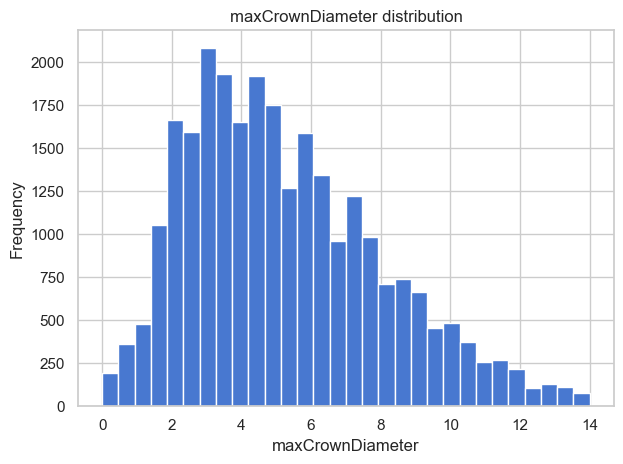

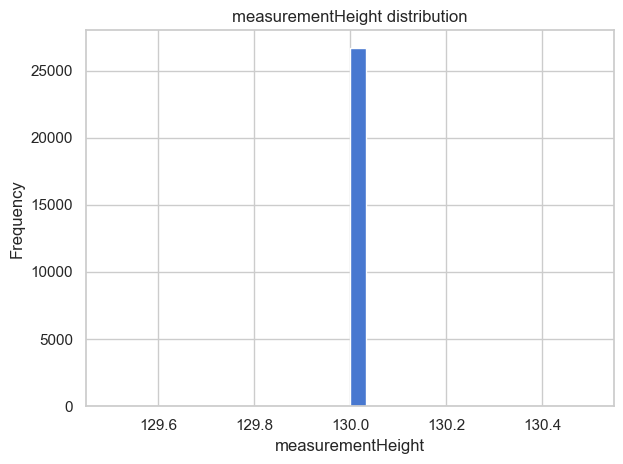

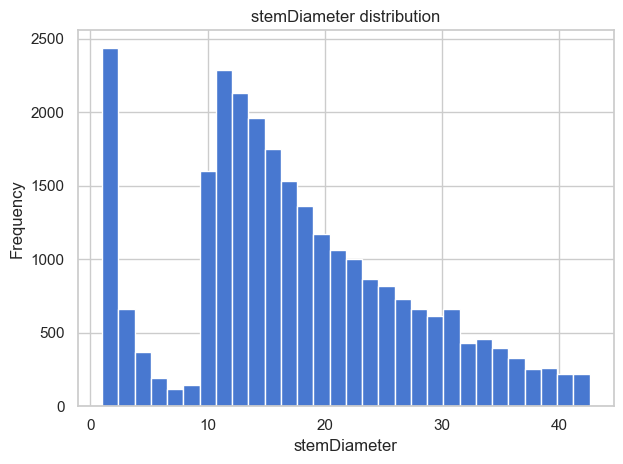

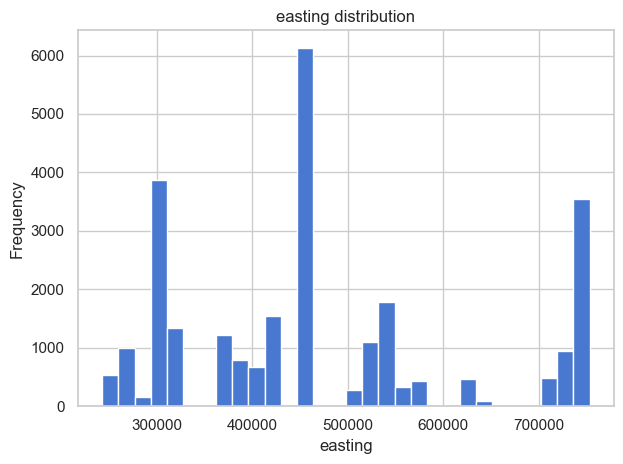

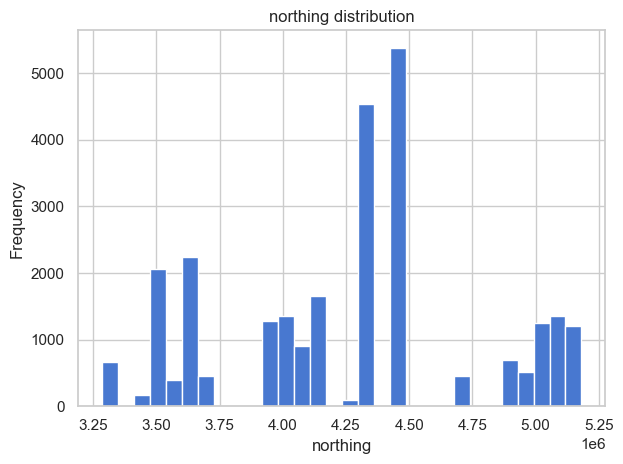

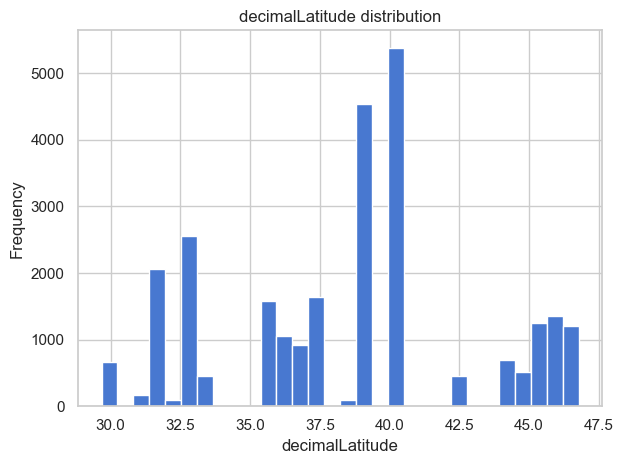

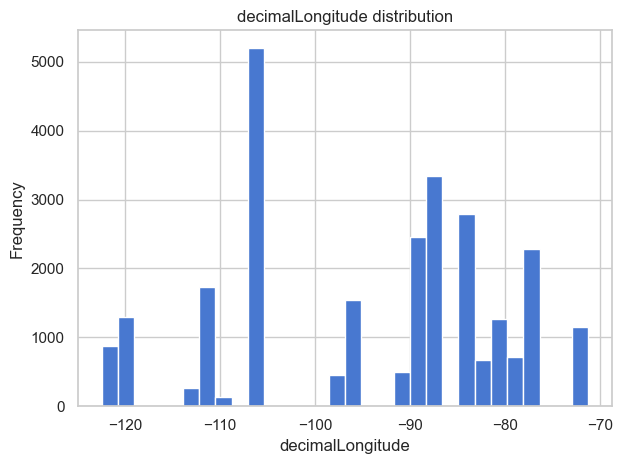

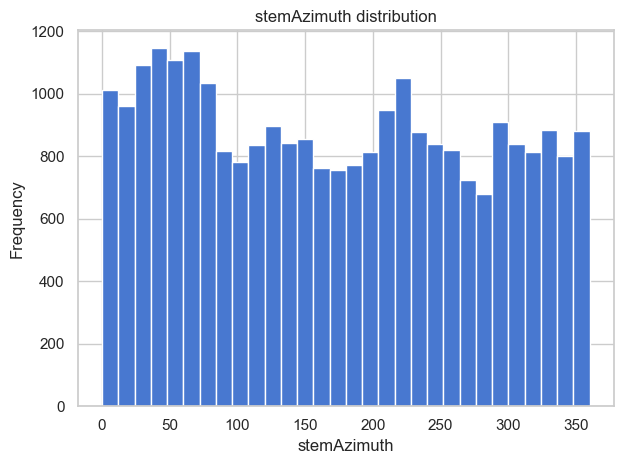

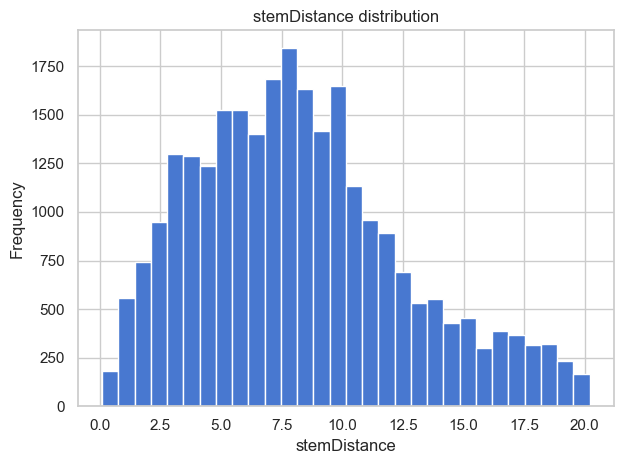

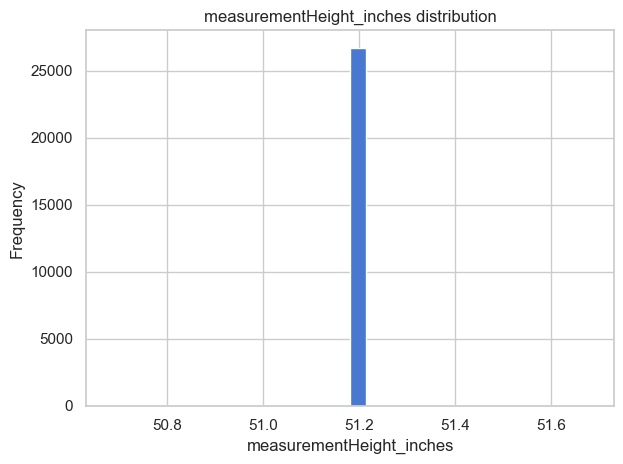

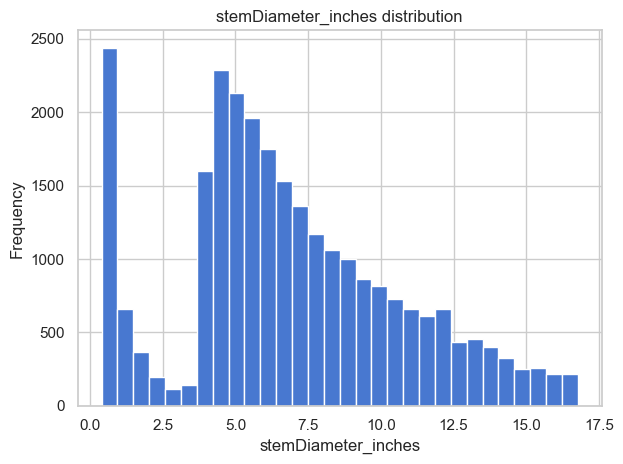

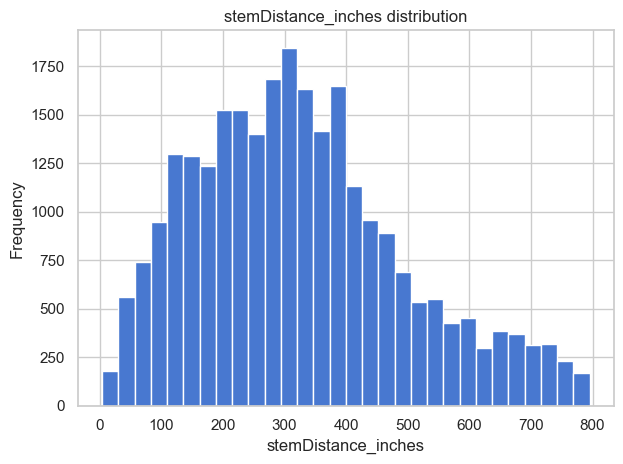

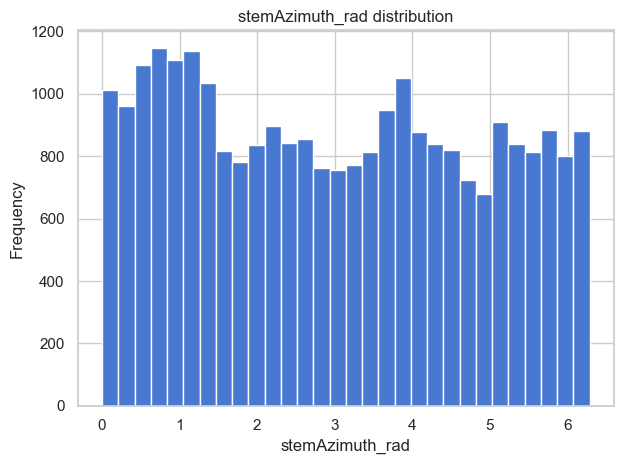

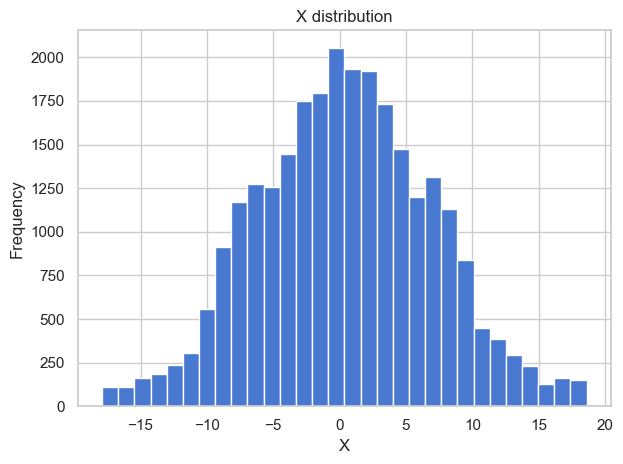

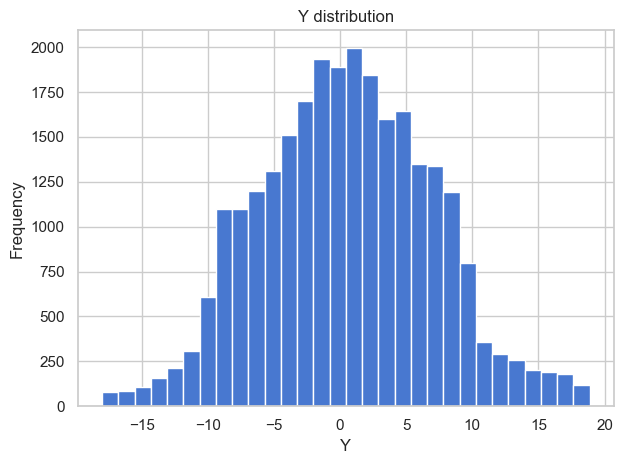

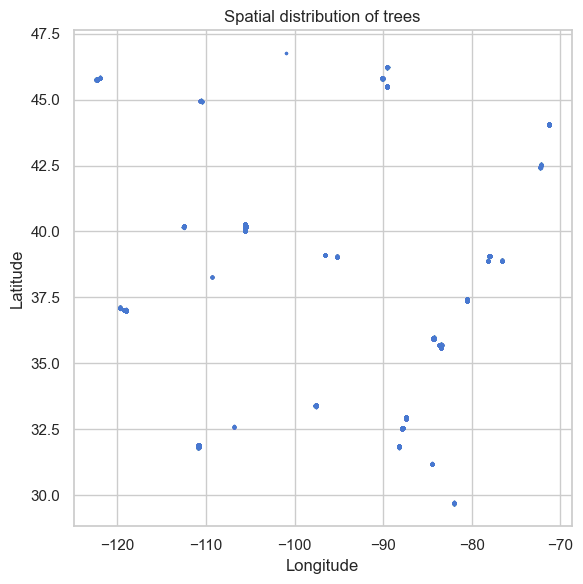

In [27]:
COLUMNS = [
    'plotID', 'individualID', 'growthForm', 'plantStatus',
    'maxCrownDiameter', 'scientificName', 'taxonID', 'genus', 'family',
    'filename', 'measurementHeight', 'stemDiameter',
    'easting', 'northing', 'utmZone', 'decimalLatitude', 'decimalLongitude',
    'stemAzimuth', 'stemDistance', 'measurementHeight_inches',
    'stemDiameter_inches', 'stemDistance_inches', 'stemAzimuth_rad',
    'X', 'Y', 'site'
]

# Numeric columns to summarize and detect outliers on
NUMERIC_COLS = [
    'maxCrownDiameter', 'measurementHeight', 'stemDiameter',
    'easting', 'northing', 'decimalLatitude', 'decimalLongitude',
    'stemAzimuth', 'stemDistance',
    'measurementHeight_inches', 'stemDiameter_inches',
    'stemDistance_inches', 'stemAzimuth_rad',
    'X', 'Y'
]

# ─── 4. Outlier detection & removal (IQR method) ───────────────────────────────
outlier_counts = {}
for col in NUMERIC_COLS:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    mask = (df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)
    outlier_counts[col] = mask.sum()
    # remove
    df = df.loc[~mask]

# build outlier DataFrame
outlier_df = (
    pd.Series(outlier_counts, name="outlier_count")
      .to_frame()
)
outlier_df['outlier_pct'] = outlier_df['outlier_count'] / len(df) * 100

# ─── 5. After‐cleaning counts ───────────────────────────────────────────────────
unique_species = df['scientificName'].nunique()
total_trees    = len(df)
unique_plots   = df['plotID'].nunique()

print(f"After‐cleaning: {total_trees} trees, {unique_species} species, {unique_plots} plots")

# ─── 6. Numeric summary statistics ──────────────────────────────────────────────
stats = df[NUMERIC_COLS].agg(['min','max','mean','median','std']).T
print("\nNumeric summary stats:")
print(stats)

# ─── 7. Top species frequencies ─────────────────────────────────────────────────
species_freq = (
    df['scientificName']
      .value_counts()
      .rename("count")
      .to_frame()
)
species_freq['pct'] = species_freq['count'] / len(df) * 100
print("\nTop 10 species:")
print(species_freq.head(10))

print("\nOutlier counts & percentages:")
print(outlier_df)

# ─── 9. Visualizations ──────────────────────────────────────────────────────────
# Histograms
for col in NUMERIC_COLS:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Spatial scatter
plt.figure(figsize=(6,6))
plt.scatter(df['decimalLongitude'], df['decimalLatitude'], s=2, alpha=0.6)
plt.title("Spatial distribution of trees")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

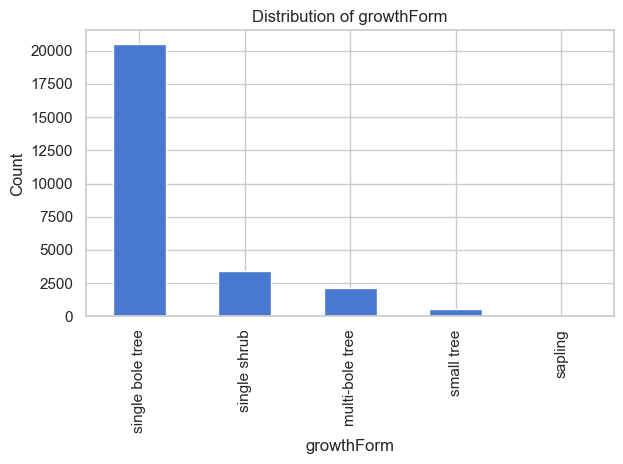

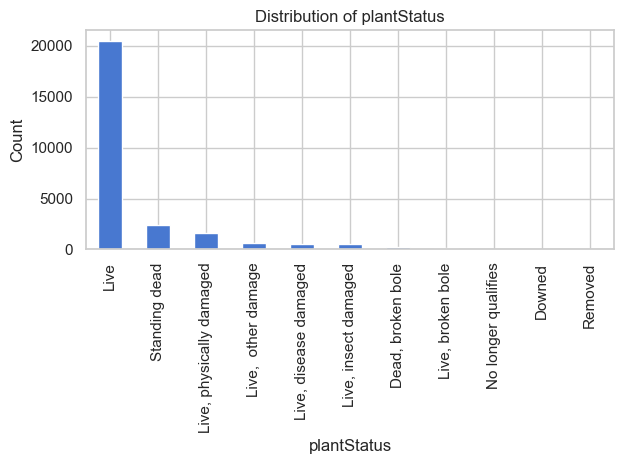

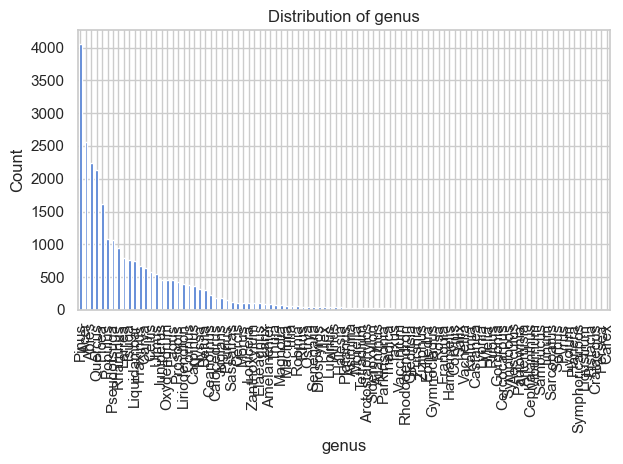

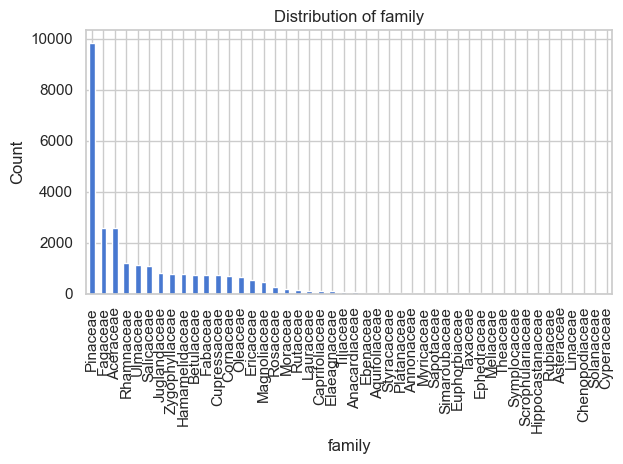

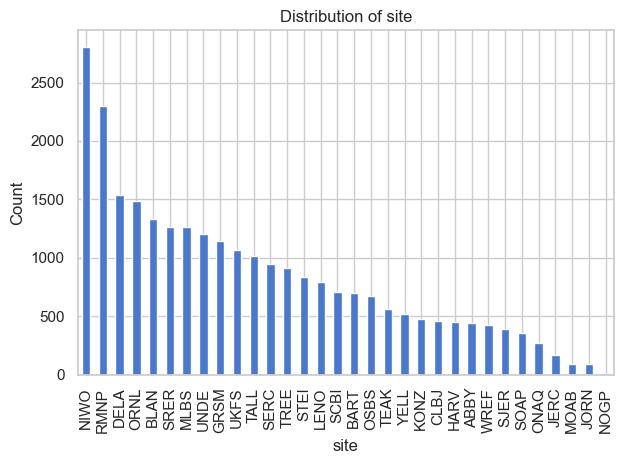

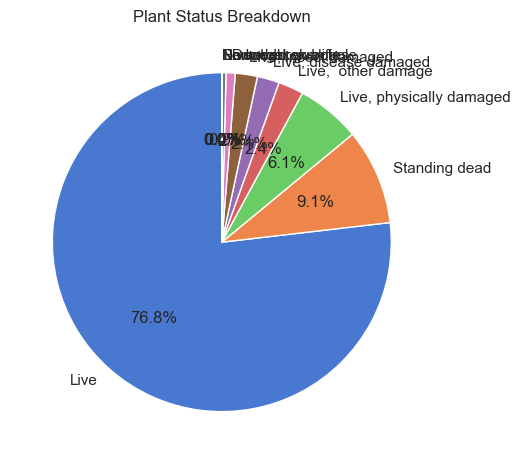

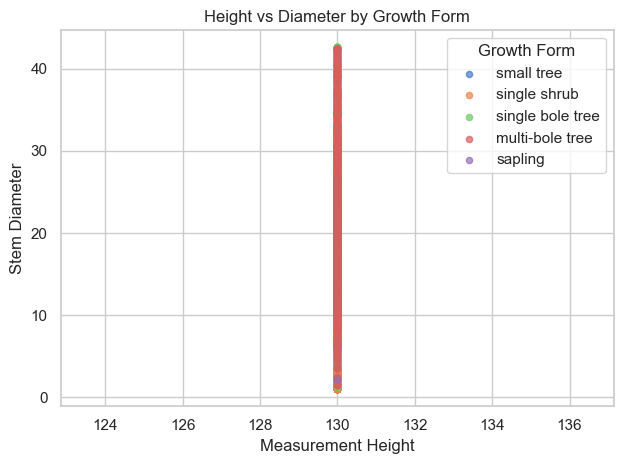

In [28]:
# load your data however is appropriate
# df = pd.read_csv("your_data.csv")

# 1) BAR CHARTS FOR CATEGORICALS
cats = ["growthForm", "plantStatus", "genus", "family", "site"]
for col in cats:
    counts = df[col].value_counts(dropna=False)
    plt.figure()
    counts.plot(kind="bar")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


# 2) PIE CHART FOR PLANT STATUS (example)
status_counts = df["plantStatus"].value_counts(dropna=False)
plt.figure()
status_counts.plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={"edgecolor": "w"},
)
plt.title("Plant Status Breakdown")
plt.ylabel("")    # hide the default ylabel
plt.tight_layout()
plt.show()


# 3) HISTOGRAMS / DISTRIBUTIONS FOR NUMERIC COLUMNS
num_cols = [
    "maxCrownDiameter",
    "measurementHeight",
    "stemDiameter",
    "stemDistance",
    "stemAzimuth_rad",
]

# 4) SCATTERPLOTS TO CHECK RELATIONSHIPS
#   a) Height vs Diameter (colored by growth form)
forms = df["growthForm"].dropna().unique()
colors = plt.cm.tab10(range(len(forms)))
plt.figure()
for form, c in zip(forms, colors):
    sub = df[df["growthForm"] == form]
    plt.scatter(
        sub["measurementHeight"],
        sub["stemDiameter"],
        label=form,
        s=20,
        alpha=0.7,
    )
plt.legend(title="Growth Form")
plt.xlabel("Measurement Height")
plt.ylabel("Stem Diameter")
plt.title("Height vs Diameter by Growth Form")
plt.tight_layout()
plt.show()

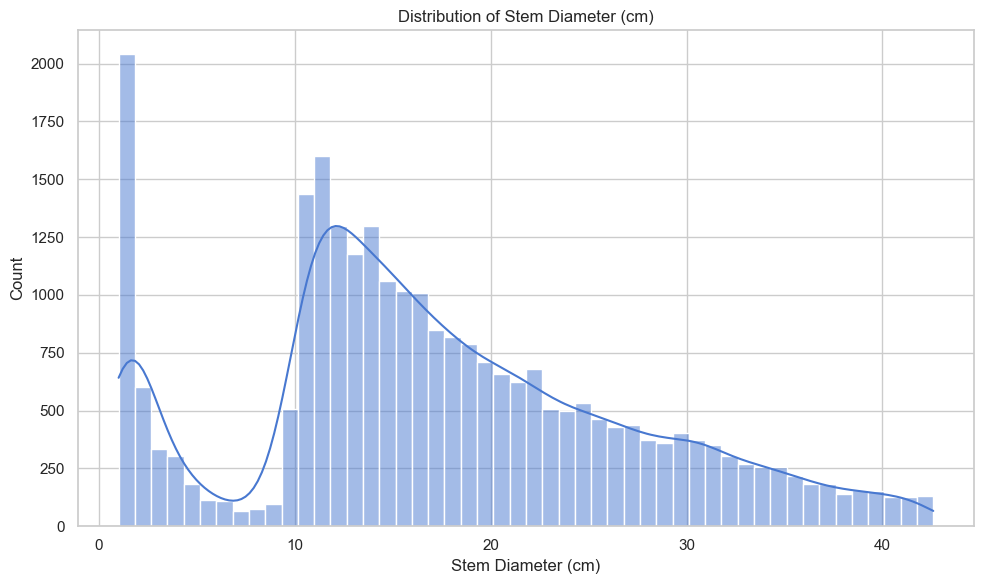

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(df['stemDiameter'], bins=50, kde=True)
plt.title('Distribution of Stem Diameter (cm)')
plt.xlabel('Stem Diameter (cm)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

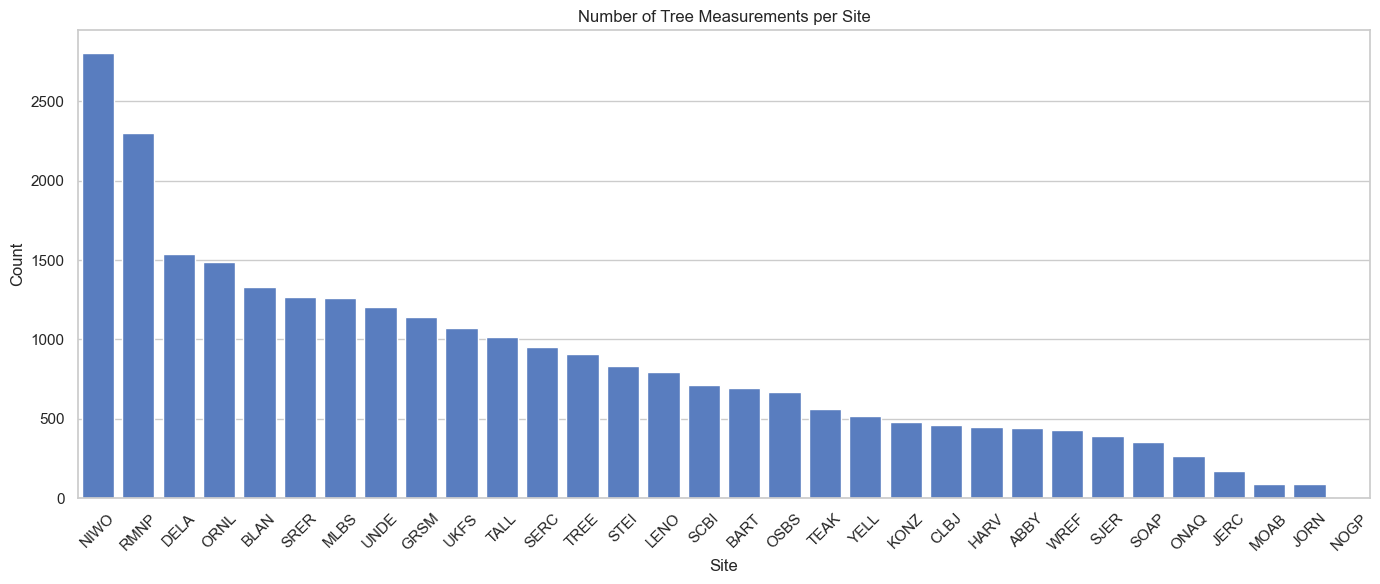

In [30]:
plt.figure(figsize=(14, 6))
site_counts = df['site'].value_counts().sort_values(ascending=False)
sns.barplot(x=site_counts.index, y=site_counts.values)
plt.title('Number of Tree Measurements per Site')
plt.xlabel('Site')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

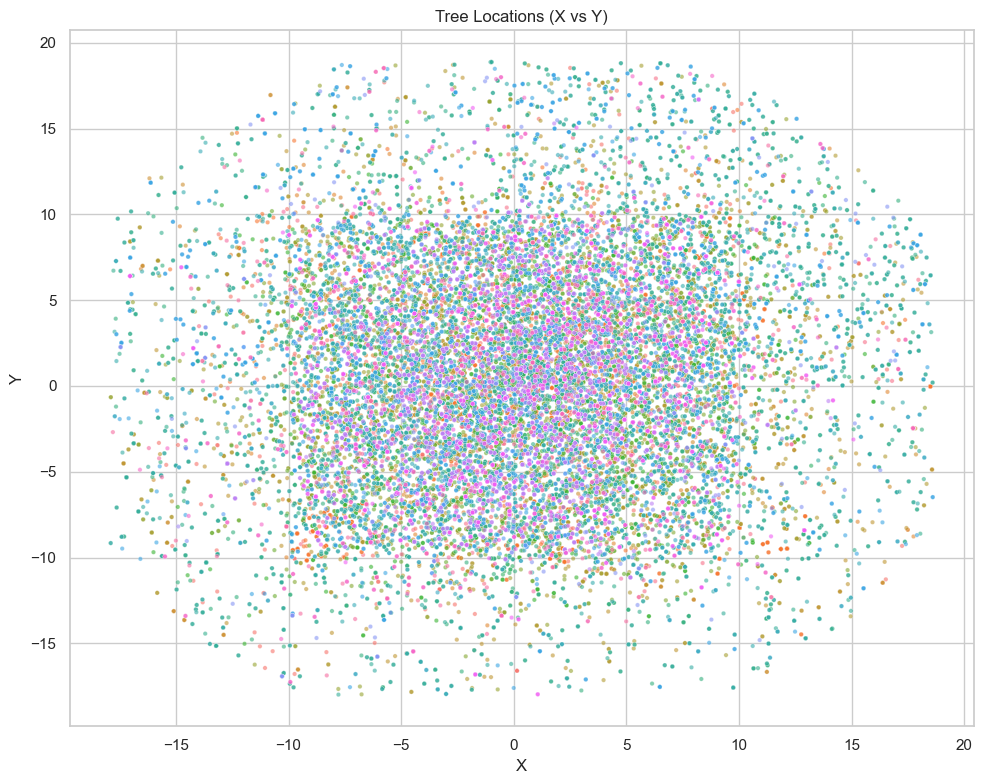

In [31]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='X', y='Y', hue='site', s=10, alpha=0.6, legend=False)
plt.title('Tree Locations (X vs Y)')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()